In [7]:
import torch
from torch import nn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [27]:
class PostionalEncoding(nn.Module):
    def __init__(self, d_model, max_len, device):
        super(PostionalEncoding, self).__init__()
        self.encoding = torch.zeros(max_len, d_model, device=device)
        self.encoding.requires_grad = False
        
        pos = torch.arange(0, max_len, device=device)
        pos = pos.float().unsqueeze(dim=1)
        
        _2i = torch.arange(0, d_model, step=2, device=device).float()
        
        self.encoding[:, 0::2] = torch.sin(pos / (10000 ** (_2i / d_model)))
        self.encoding[:, 1::2] = torch.cos(pos / (10000 ** (_2i / d_model)))

    def forward(self, x):
        batch_size, seq_len = x.size()
        return self.encoding[:seq_len, :]
    
position = PostionalEncoding(512,1000,device)

In [28]:
import math
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data

# S: Symbol that shows starting of decoding input
# E: Symbol that shows starting of decoding output
# P: Symbol that will fill in blank sequence if current batch data size is short than time steps
sentences = [
        # enc_input           dec_input         dec_output
        ['ich mochte ein bier P', 'S i want a beer .', 'i want a beer . E'],
        ['ich mochte ein cola P', 'S i want a coke .', 'i want a coke . E']
]

# Padding Should be Zero
src_vocab = {'P' : 0, 'ich' : 1, 'mochte' : 2, 'ein' : 3, 'bier' : 4, 'cola' : 5}
src_vocab_size = len(src_vocab)

tgt_vocab = {'P' : 0, 'i' : 1, 'want' : 2, 'a' : 3, 'beer' : 4, 'coke' : 5, 'S' : 6, 'E' : 7, '.' : 8}
idx2word = {i: w for i, w in enumerate(tgt_vocab)}
tgt_vocab_size = len(tgt_vocab)

src_len = 5 # enc_input max sequence length
tgt_len = 6 # dec_input(=dec_output) max sequence length

def make_data(sentences):
    enc_inputs, dec_inputs, dec_outputs = [], [], []
    for i in range(len(sentences)):
      enc_input = [[src_vocab[n] for n in sentences[i][0].split()]] # [[1, 2, 3, 4, 0], [1, 2, 3, 5, 0]]
      dec_input = [[tgt_vocab[n] for n in sentences[i][1].split()]] # [[6, 1, 2, 3, 4, 8], [6, 1, 2, 3, 5, 8]]
      dec_output = [[tgt_vocab[n] for n in sentences[i][2].split()]] # [[1, 2, 3, 4, 8, 7], [1, 2, 3, 5, 8, 7]]

      enc_inputs.extend(enc_input)
      dec_inputs.extend(dec_input)
      dec_outputs.extend(dec_output)

    return torch.LongTensor(enc_inputs), torch.LongTensor(dec_inputs), torch.LongTensor(dec_outputs)

enc_inputs, dec_inputs, dec_outputs = make_data(sentences)

class MyDataSet(Data.Dataset):
  def __init__(self, enc_inputs, dec_inputs, dec_outputs):
    super(MyDataSet, self).__init__()
    self.enc_inputs = enc_inputs
    self.dec_inputs = dec_inputs
    self.dec_outputs = dec_outputs
  
  def __len__(self):
    return self.enc_inputs.shape[0]
  
  def __getitem__(self, idx):
    return self.enc_inputs[idx], self.dec_inputs[idx], self.dec_outputs[idx]

loader = Data.DataLoader(MyDataSet(enc_inputs, dec_inputs, dec_outputs), 2, True)

In [29]:
enc_inputs, dec_inputs, dec_outputs

(tensor([[1, 2, 3, 4, 0],
         [1, 2, 3, 5, 0]]),
 tensor([[6, 1, 2, 3, 4, 8],
         [6, 1, 2, 3, 5, 8]]),
 tensor([[1, 2, 3, 4, 8, 7],
         [1, 2, 3, 5, 8, 7]]))

In [31]:
def get_attn_pad_mask(seq_q, seq_k):
    '''
    seq_q: [batch_size, seq_len]
    seq_k: [batch_size, seq_len]
    seq_len could be src_len or it could be tgt_len
    seq_len in seq_q and seq_len in seq_k maybe not equal
    '''
    batch_size, len_q = seq_q.size()
    batch_size, len_k = seq_k.size()
    # eq(zero) is PAD token
    pad_attn_mask = seq_k.data.eq(0).unsqueeze(1)  # [batch_size, 1, len_k], True is masked
    return pad_attn_mask.expand(batch_size, len_q, len_k)  # [batch_size, len_q, len_k]
seq_q = torch.from_numpy(np.array([1,2,3,4,0]))
seq_k = torch.from_numpy(np.array([1,2,3,4,0]))
get_attn_pad_mask(seq_q,seq_k)

ValueError: not enough values to unpack (expected 2, got 1)

In [33]:
from d2l import torch as d2l
num_hiddens, num_layers, dropout, batch_size, num_steps = 32, 2, 0.1, 64, 10
lr, num_epochs, device = 0.005, 200, d2l.try_gpu()
ffn_num_input, ffn_num_hiddens, num_heads = 32, 64, 4
key_size, query_size, value_size = 32, 32, 32
norm_shape = [32]

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)

UnicodeDecodeError: 'gbk' codec can't decode byte 0xaf in position 33: illegal multibyte sequence

In [1]:
import math
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
#@save
class MultiHeadAttention(nn.Module):
    """多头注意力"""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 num_heads, dropout, bias=False, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.attention = d2l.DotProductAttention(dropout)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=bias)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=bias)
        self.W_v = nn.Linear(value_size, num_hiddens, bias=bias)
        self.W_o = nn.Linear(num_hiddens, num_hiddens, bias=bias)

    def forward(self, queries, keys, values, valid_lens):
        # queries，keys，values的形状:
        # (batch_size，查询或者“键－值”对的个数，num_hiddens)
        # valid_lens　的形状:
        # (batch_size，)或(batch_size，查询的个数)
        # 经过变换后，输出的queries，keys，values　的形状:
        # (batch_size*num_heads，查询或者“键－值”对的个数，
        # num_hiddens/num_heads)
        queries = transpose_qkv(self.W_q(queries), self.num_heads)
        keys = transpose_qkv(self.W_k(keys), self.num_heads)
        values = transpose_qkv(self.W_v(values), self.num_heads)

        if valid_lens is not None:
            # 在轴0，将第一项（标量或者矢量）复制num_heads次，
            # 然后如此复制第二项，然后诸如此类。
            valid_lens = torch.repeat_interleave(
                valid_lens, repeats=self.num_heads, dim=0)

        # output的形状:(batch_size*num_heads，查询的个数，
        # num_hiddens/num_heads)
        output = self.attention(queries, keys, values, valid_lens)

        # output_concat的形状:(batch_size，查询的个数，num_hiddens)
        output_concat = transpose_output(output, self.num_heads)
        return self.W_o(output_concat)
#@save
def transpose_qkv(X, num_heads):
    """为了多注意力头的并行计算而变换形状"""
    # 输入X的形状:(batch_size，查询或者“键－值”对的个数，num_hiddens)
    # 输出X的形状:(batch_size，查询或者“键－值”对的个数，num_heads，
    # num_hiddens/num_heads)
    X = X.reshape(X.shape[0], X.shape[1], num_heads, -1)

    # 输出X的形状:(batch_size，num_heads，查询或者“键－值”对的个数,
    # num_hiddens/num_heads)
    X = X.permute(0, 2, 1, 3)

    # 最终输出的形状:(batch_size*num_heads,查询或者“键－值”对的个数,
    # num_hiddens/num_heads)
    return X.reshape(-1, X.shape[2], X.shape[3])


#@save
def transpose_output(X, num_heads):
    """逆转transpose_qkv函数的操作"""
    X = X.reshape(-1, num_heads, X.shape[1], X.shape[2])
    X = X.permute(0, 2, 1, 3)
    return X.reshape(X.shape[0], X.shape[1], -1)

num_hiddens, num_heads = 100, 5
attention = MultiHeadAttention(num_hiddens, num_hiddens, num_hiddens,
                               num_hiddens, num_heads, 0.5)
attention.eval()

MultiHeadAttention(
  (attention): DotProductAttention(
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (W_q): Linear(in_features=100, out_features=100, bias=False)
  (W_k): Linear(in_features=100, out_features=100, bias=False)
  (W_v): Linear(in_features=100, out_features=100, bias=False)
  (W_o): Linear(in_features=100, out_features=100, bias=False)
)

In [6]:
batch_size, num_queries = 2, 4
num_kvpairs, valid_lens =  6, torch.tensor([3, 2])
X = torch.ones((batch_size, num_queries, num_hiddens))
Y = torch.ones((batch_size, num_kvpairs, num_hiddens))
# attention(X, Y, Y, valid_lens).shape
X.shape,Y.shape,valid_lens.shape

(torch.Size([2, 4, 100]), torch.Size([2, 6, 100]), torch.Size([2]))

In [7]:
valid_lens

tensor([3, 2])

In [8]:
import os
import torch
from d2l import torch as d2l

In [16]:
#@save
d2l.DATA_HUB['fra-eng'] = (d2l.DATA_URL + 'fra-eng.zip',
                           '94646ad1522d915e7b0f9296181140edcf86a4f5')

#@save
def read_data_nmt():
    """载入“英语－法语”数据集"""
    data_dir = d2l.download_extract('fra-eng')
    with open(os.path.join(data_dir, 'fra.txt'), 'r',
             encoding='utf-8') as f:
        return f.read()

raw_text = read_data_nmt()
print(raw_text[0:75])

Go.	Va !
Hi.	Salut !
Run!	Cours !
Run!	Courez !
Who?	Qui ?
Wow!	Ça alors !



In [17]:
#@save
def preprocess_nmt(text):
    """预处理“英语－法语”数据集"""
    def no_space(char, prev_char):
        return char in set(',.!?') and prev_char != ' '

    # 使用空格替换不间断空格
    # 使用小写字母替换大写字母
    text = text.replace('\u202f', ' ').replace('\xa0', ' ').lower()
    # 在单词和标点符号之间插入空格
    out = [' ' + char if i > 0 and no_space(char, text[i - 1]) else char
           for i, char in enumerate(text)]
    return ''.join(out)

text = preprocess_nmt(raw_text)
print(text[:80])

go .	va !
hi .	salut !
run !	cours !
run !	courez !
who ?	qui ?
wow !	ça alors !


In [18]:
#@save
def tokenize_nmt(text, num_examples=None):
    """词元化“英语－法语”数据数据集"""
    source, target = [], []
    for i, line in enumerate(text.split('\n')):
        if num_examples and i > num_examples:
            break
        parts = line.split('\t')
        if len(parts) == 2:
            source.append(parts[0].split(' '))
            target.append(parts[1].split(' '))
    return source, target

source, target = tokenize_nmt(text)
source[:6], target[:6]

([['go', '.'],
  ['hi', '.'],
  ['run', '!'],
  ['run', '!'],
  ['who', '?'],
  ['wow', '!']],
 [['va', '!'],
  ['salut', '!'],
  ['cours', '!'],
  ['courez', '!'],
  ['qui', '?'],
  ['ça', 'alors', '!']])

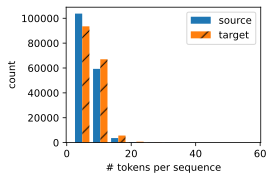

In [20]:
def show_list_len_pair_hist(legend, xlabel, ylabel, xlist, ylist):
    """绘制列表长度对的直方图"""
    d2l.set_figsize()
    _, _, patches = d2l.plt.hist(
        [[len(l) for l in xlist], [len(l) for l in ylist]])
    d2l.plt.xlabel(xlabel)
    d2l.plt.ylabel(ylabel)
    for patch in patches[1].patches:
        patch.set_hatch('/')
    d2l.plt.legend(legend)

show_list_len_pair_hist(['source', 'target'], '# tokens per sequence',
                        'count', source, target);

In [21]:
src_vocab = d2l.Vocab(source, min_freq=2,
                      reserved_tokens=['<pad>', '<bos>', '<eos>'])
len(src_vocab)

10012

In [28]:
#@save
def truncate_pad(line, num_steps, padding_token):
    """截断或填充文本序列"""
    if len(line) > num_steps:
        return line[:num_steps]  # 截断
    return line + [padding_token] * (num_steps - len(line))  # 填充

truncate_pad(src_vocab[source[0]], 10, src_vocab['<pad>'])

[47, 4, 1, 1, 1, 1, 1, 1, 1, 1]

In [29]:
#@save
def build_array_nmt(lines, vocab, num_steps):
    """将机器翻译的文本序列转换成小批量"""
    lines = [vocab[l] for l in lines]
    lines = [l + [vocab['<eos>']] for l in lines]
    array = torch.tensor([truncate_pad(
        l, num_steps, vocab['<pad>']) for l in lines])
    valid_len = (array != vocab['<pad>']).type(torch.int32).sum(1)
    return array, valid_len

In [30]:
#@save
def load_data_nmt(batch_size, num_steps, num_examples=600):
    """返回翻译数据集的迭代器和词表"""
    text = preprocess_nmt(read_data_nmt())
    source, target = tokenize_nmt(text, num_examples)
    src_vocab = d2l.Vocab(source, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    tgt_vocab = d2l.Vocab(target, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    src_array, src_valid_len = build_array_nmt(source, src_vocab, num_steps)
    tgt_array, tgt_valid_len = build_array_nmt(target, tgt_vocab, num_steps)
    data_arrays = (src_array, src_valid_len, tgt_array, tgt_valid_len)
    data_iter = d2l.load_array(data_arrays, batch_size)
    return data_iter, src_vocab, tgt_vocab

In [41]:
train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size=2, num_steps=8)
for X, X_valid_len, Y, Y_valid_len in train_iter:
    print('X:', X.type(torch.int32))
    print('X的有效长度:', X_valid_len)
    print('Y:', Y.type(torch.int32))
    print('Y的有效长度:', Y_valid_len)
    break

X: tensor([[ 52,   0,   4,   3,   1,   1,   1,   1],
        [  6, 145,   4,   3,   1,   1,   1,   1]], dtype=torch.int32)
X的有效长度: tensor([4, 4])
Y: tensor([[30,  0, 22,  4,  3,  1,  1,  1],
        [ 6, 27,  7,  0,  4,  3,  1,  1]], dtype=torch.int32)
Y的有效长度: tensor([5, 6])


In [33]:
import math
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

In [34]:
#@save
class PositionWiseFFN(nn.Module):
    """基于位置的前馈网络"""
    def __init__(self, ffn_num_input, ffn_num_hiddens, ffn_num_outputs,
                 **kwargs):
        super(PositionWiseFFN, self).__init__(**kwargs)
        self.dense1 = nn.Linear(ffn_num_input, ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(ffn_num_hiddens, ffn_num_outputs)

    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))

In [38]:
ffn = PositionWiseFFN(4, 4, 8)
ffn.eval()
ffn(torch.ones((2, 3, 4)))[0].shape

torch.Size([3, 8])

In [39]:
#@save
class AddNorm(nn.Module):
    """残差连接后进行层规范化"""
    def __init__(self, normalized_shape, dropout, **kwargs):
        super(AddNorm, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(normalized_shape)

    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)

In [40]:
add_norm = AddNorm([3, 4], 0.5)
add_norm.eval()
add_norm(torch.ones((2, 3, 4)), torch.ones((2, 3, 4))).shape

torch.Size([2, 3, 4])

In [1]:
# 包
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.utils import save_image

In [3]:
# 设备配置
torch.cuda.set_device(0) # 这句用来设置pytorch在哪块GPU上运行
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# 如果没有文件夹就创建一个文件夹
sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)


In [5]:
# 超参数设置
# Hyper-parameters
image_size = 784
h_dim = 400
z_dim = 20
num_epochs = 15
batch_size = 128
learning_rate = 1e-3

In [6]:
dataset = torchvision.datasets.MNIST(root='./data/minist',
                                     train=True,
                                     transform=transforms.ToTensor(),
                                     download=True)

# 数据加载器
data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                          batch_size=batch_size, 
                                          shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/minist\MNIST\raw\train-images-idx3-ubyte.gz to ./data/minist\MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/minist\MNIST\raw\train-labels-idx1-ubyte.gz to ./data/minist\MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/minist\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data/minist\MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/minist\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data/minist\MNIST\raw



In [7]:
# VAE model
class VAE(nn.Module):
    def __init__(self, image_size=784, h_dim=400, z_dim=20):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(image_size, h_dim)
        self.fc2 = nn.Linear(h_dim, z_dim) # 均值 向量
        self.fc3 = nn.Linear(h_dim, z_dim) # 保准方差 向量
        self.fc4 = nn.Linear(z_dim, h_dim)
        self.fc5 = nn.Linear(h_dim, image_size)
        
    # 编码过程
    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc2(h), self.fc3(h)
    
    # 随机生成隐含向量
    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu + eps * std

    # 解码过程
    def decode(self, z):
        h = F.relu(self.fc4(z))
        return F.sigmoid(self.fc5(h))
    
    # 整个前向传播过程：编码-》解码
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_reconst = self.decode(z)
        return x_reconst, mu, log_var


In [8]:
# 实例化一个模型
model = VAE().to(device)

In [9]:
# 创建优化器
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [10]:
for epoch in range(num_epochs):
    for i, (x, _) in enumerate(data_loader):
        # 获取样本，并前向传播
        x = x.to(device).view(-1, image_size)
        x_reconst, mu, log_var = model(x)
        
        # 计算重构损失和KL散度（KL散度用于衡量两种分布的相似程度）
        # KL散度的计算可以参考论文或者文章开头的链接
        reconst_loss = F.binary_cross_entropy(x_reconst, x, size_average=False)
        kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        
        # 反向传播和优化
        loss = reconst_loss + kl_div
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}" 
                   .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item(), kl_div.item()))
    
    # 利用训练的模型进行测试
    with torch.no_grad():
        # 随机生成的图像
        z = torch.randn(batch_size, z_dim).to(device)
        out = model.decode(z).view(-1, 1, 28, 28)
        save_image(out, os.path.join(sample_dir, 'sampled-{}.png'.format(epoch+1)))

        # 重构的图像
        out, _, _ = model(x)
        x_concat = torch.cat([x.view(-1, 1, 28, 28), out.view(-1, 1, 28, 28)], dim=3)
        save_image(x_concat, os.path.join(sample_dir, 'reconst-{}.png'.format(epoch+1)))


D:\anaconda3\lib\site-packages\torch\nn\functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
D:\anaconda3\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch[1/15], Step [100/469], Reconst Loss: 21651.2031, KL Div: 1442.1257
Epoch[1/15], Step [200/469], Reconst Loss: 17567.5938, KL Div: 1946.8011
Epoch[1/15], Step [300/469], Reconst Loss: 16377.9277, KL Div: 2416.3613
Epoch[1/15], Step [400/469], Reconst Loss: 13912.9980, KL Div: 2587.4622
Epoch[2/15], Step [100/469], Reconst Loss: 12774.5898, KL Div: 2739.5884
Epoch[2/15], Step [200/469], Reconst Loss: 12757.5430, KL Div: 2993.8813
Epoch[2/15], Step [300/469], Reconst Loss: 12170.8154, KL Div: 3070.0400
Epoch[2/15], Step [400/469], Reconst Loss: 12416.3301, KL Div: 2984.1782
Epoch[3/15], Step [100/469], Reconst Loss: 11411.1973, KL Div: 3081.6465
Epoch[3/15], Step [200/469], Reconst Loss: 11406.4141, KL Div: 3060.6636
Epoch[3/15], Step [300/469], Reconst Loss: 11383.1768, KL Div: 3171.5164
Epoch[3/15], Step [400/469], Reconst Loss: 11921.3066, KL Div: 3296.6785
Epoch[4/15], Step [100/469], Reconst Loss: 11356.4023, KL Div: 3129.4841
Epoch[4/15], Step [200/469], Reconst Loss: 10797.32

In [13]:
for epoch in range(num_epochs):
    for i, (x, _) in enumerate(data_loader):
        # 获取样本，并前向传播
        x = x.to(device).view(-1, 784)
        print(x.shape) 
        break
    break

torch.Size([128, 784])
